## Work
1. 請自行定義一個 loss function, 為 0.3 * focal loss + 0.7 cross-entropy，訓練並比較結果


In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.regularizers import l1_l2
from keras.layers import Input, Dense, BatchNormalization, Dropout
from keras.models import Model

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_l2_ratio=1e-8, drp_ratio=0.2):
    """Code Here
    建立你的神經網路
    """
    input_layer = Input(input_shape)
    x = BatchNormalization()(input_layer)
    
    for i, n_units in enumerate(num_neurons):
        x = Dense(units=n_units, 
                               activation="relu", 
                               name="hidden_layer"+str(i+1),
                               kernel_regularizer=l1_l2(l1_l2_ratio))(x)
        x = BatchNormalization()(x)
        x = Dropout(drp_ratio)(x)
    
    out = Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 25
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [7]:
import tensorflow as tf
import keras.backend as K

"""Code Here
撰寫一個 loss function, 使其可以結合 focal loss 與 crossentropy loss
"""
def combined_loss(gamma=2, alpha=4):
    """Define the customized loss."""
    gamma = float(gamma)
    alpha = float(alpha)
    def focal_loss_fixed(y_true, y_pred):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        """
        epsilon = 1e-8
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.math.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        
        cce = keras.losses.CategoricalCrossentropy()
        
        return tf.multiply(tf.multiply(0.3, tf.reduce_mean(reduced_fl)), tf.multiply(0.7, cce(y_true, y_pred)))
    return focal_loss_fixed

ce_weights_list = [0., 0.3, 0.5, 0.7, 1]

In [8]:
import itertools
results = {}

for i, ce_w in enumerate(ce_weights_list):
    print("Numbers of exp: %i, ce_weight: %.2f" % (i, ce_w))

    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    """Code Here
    將自定義的 loss function 加入模型
    """
    model.compile(loss=combined_loss(), metrics=["accuracy"], optimizer=optimizer)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True
             )
    
    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, ce_weight: 0.00
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
batch_normalization (BatchNo (None, 3072)              12288     
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Bat

Epoch 6/25
49/49 [==============================] - 1s 21ms/step - loss: 12.8630 - accuracy: 0.4403 - val_loss: 12.7117 - val_accuracy: 0.4325
Epoch 7/25
49/49 [==============================] - 1s 22ms/step - loss: 12.3425 - accuracy: 0.4513 - val_loss: 12.1430 - val_accuracy: 0.4502
Epoch 8/25
49/49 [==============================] - 1s 21ms/step - loss: 11.8665 - accuracy: 0.4640 - val_loss: 11.6393 - val_accuracy: 0.4671
Epoch 9/25
49/49 [==============================] - 1s 22ms/step - loss: 11.3992 - accuracy: 0.4717 - val_loss: 11.1680 - val_accuracy: 0.4815
Epoch 10/25
49/49 [==============================] - 1s 22ms/step - loss: 10.9669 - accuracy: 0.4815 - val_loss: 10.7378 - val_accuracy: 0.4885
Epoch 11/25
49/49 [==============================] - 1s 21ms/step - loss: 10.5476 - accuracy: 0.4844 - val_loss: 10.3304 - val_accuracy: 0.4935
Epoch 12/25
49/49 [==============================] - 1s 22ms/step - loss: 10.1519 - accuracy: 0.4949 - val_loss: 9.9481 - val_accuracy: 0.50

49/49 [==============================] - 1s 22ms/step - loss: 6.4089 - accuracy: 0.5618 - val_loss: 6.4555 - val_accuracy: 0.5348
Epoch 25/25
49/49 [==============================] - 1s 21ms/step - loss: 6.1781 - accuracy: 0.5652 - val_loss: 6.2338 - val_accuracy: 0.5349
Numbers of exp: 3, ce_weight: 0.70
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 3072)              12288     
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_13 (Batc (None, 512)               2048      
_________________________________________________________________
dropout_9 (Dropo

Epoch 4/25
49/49 [==============================] - 1s 23ms/step - loss: 14.0040 - accuracy: 0.4079 - val_loss: 13.9753 - val_accuracy: 0.3836
Epoch 5/25
49/49 [==============================] - 1s 22ms/step - loss: 13.4223 - accuracy: 0.4234 - val_loss: 13.3337 - val_accuracy: 0.4072
Epoch 6/25
49/49 [==============================] - 1s 22ms/step - loss: 12.8757 - accuracy: 0.4386 - val_loss: 12.7047 - val_accuracy: 0.4359
Epoch 7/25
49/49 [==============================] - 1s 22ms/step - loss: 12.3455 - accuracy: 0.4493 - val_loss: 12.1482 - val_accuracy: 0.4585
Epoch 8/25
49/49 [==============================] - 1s 23ms/step - loss: 11.8736 - accuracy: 0.4593 - val_loss: 11.6349 - val_accuracy: 0.4691
Epoch 9/25
49/49 [==============================] - 1s 23ms/step - loss: 11.4089 - accuracy: 0.4664 - val_loss: 11.1707 - val_accuracy: 0.4805
Epoch 10/25
49/49 [==============================] - 1s 22ms/step - loss: 10.9700 - accuracy: 0.4784 - val_loss: 10.7357 - val_accuracy: 0.491

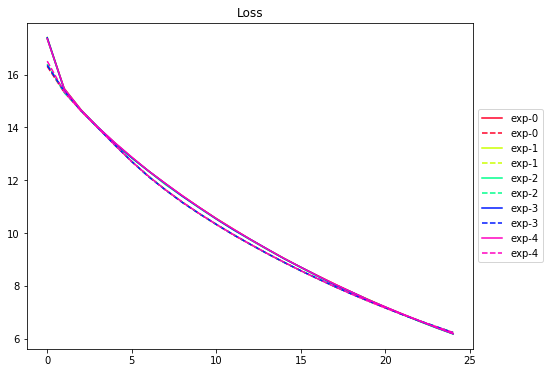

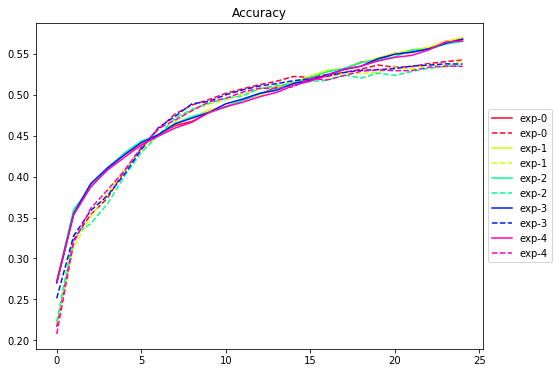

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()